In [0]:
pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 72kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.3.3
    Uninstalling scipy-1.3.3:
      Successfully uninstalled scipy-1.3.3


In [0]:

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd "/content/drive/My Drive/Colab Notebooks/data mining"

/content/drive/My Drive/Colab Notebooks/data mining


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


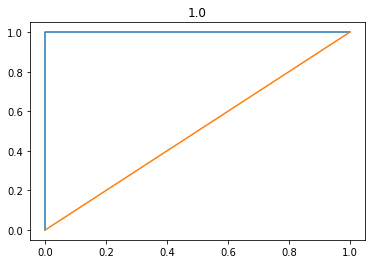

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc,accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate
from datetime import datetime,timedelta,date
import time
from sklearn.feature_selection import RFE
import os
import csv

# Loading the dataset
data = pd.read_pickle('./dataset_new.pkl')
dataset = np.zeros([15000,19])

for index in np.arange(0,15000):
    ts = data[2][index][1]
    isdef = data[6][index][1] if len(data[6][index]) else 0
    cumsum_ts = np.cumsum(ts)
    loan_amount = data[4][index][1]
    dt = datetime.strptime(data[5][index][1],'%Y-%m-%d')
    loan_date = dt.timestamp()
    dates = []
    time_val = []

    for k in data[1][index][1]:
      v = datetime.strptime(k,'%Y-%m-%d')
      val = v.timestamp()
      dates.append(v)
      time_val.append(val)

    

    time_val = np.array(time_val)
    max_date = np.max(time_val)
    min_date = np.min(time_val)
    d1 = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(max_date))
    d2 = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(min_date))
    max_dt = datetime.strptime(d1, '%Y-%m-%d %H:%M:%S')
    min_dt = datetime.strptime(d2, '%Y-%m-%d %H:%M:%S')
    d = dt.date()
    
    dmax = (d-max_dt.date()).days
    dmin = (d-min_dt.date()).days
    
    dataset[index,0] = np.sum(ts[np.where(ts>=0)])
    dataset[index,1] = np.sum(ts[np.where(ts<0)])
    dataset[index,2] = np.mean(ts[np.where(ts>=0)])
    dataset[index,3] = np.mean(ts[np.where(ts<0)])
    dataset[index,4] = np.max(ts)
    dataset[index,5] = np.min(ts)
    dataset[index,6] = loan_amount
    dataset[index,7] = len(ts[np.where(ts>=0)])
    dataset[index,8] = len(ts[np.where(ts<0)])
    dataset[index,9] = cumsum_ts[-1] - cumsum_ts[0]
    dataset[index,10] = np.sum(ts)
    dataset[index,11] = dmax
    dataset[index,12] = dmin
    dataset[index,13] = np.max(time_val)
    dataset[index,14] = np.min(time_val)
    dataset[index,15] = np.mean(time_val)
    dataset[index,16] = len(ts)
    
    _ind = np.argmax(ts)
    dataset[index,17] = (d-dates[_ind].date()).days
    dataset[index,18] = isdef

    
# spliting the dataset into train and test 
dataset[np.isnan(dataset)] = 0
DT = pd.DataFrame(data=dataset,index=np.array(range(0, dataset.shape[0])),columns=np.array(range(0, dataset.shape[1])))

x_train = DT.iloc[0:10000,:dataset.shape[1]-1]
y_train = DT.iloc[0:10000,-1]

x_test = DT.iloc[10000:10500,:dataset.shape[1]-1]
y_test = DT.iloc[10000:10500,-1]

# Takes in a model, trains the model, and evaluates the model on the test set

def fit(model,X,Y):
    model.fit(X, Y)
    return model

# Algorithm used Random Forest classifiers

algo = RandomForestClassifier(n_estimators=300,max_features='auto')
model = fit(algo,x_train,y_train)

score = model.score(x_train, y_train)
y_pred = model.predict_proba(x_train)

fpr,tpr,thresholds = roc_curve(y_train,y_pred[:,1])
roc_auccuracy = auc(fpr,tpr)
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.title(roc_auccuracy)

y_pred_Test = model.predict_proba(x_test)
plt.figure()
fpr,tpr,thresholds = roc_curve(y_test,y_pred_Test[:,1])
roc_auccuracy = auc(fpr,tpr)
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.title(roc_auccuracy)

#  Dataset and its probability for csv file
xt = DT.iloc[10000:15000,:dataset.shape[1]-1]
P= model.predict_proba(xt)

# Function to write in csv 
def write_csv(file_path, y_list):

    rs = [('id', 'category')] + [(i, y) for (i, y) in enumerate(y_list)]
    with open(file_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(rs)

 
def output_submission_csv(output_file_path, y_test):

    write_csv(output_file_path, y_test)

# output file 
ex = data.iloc[10000:15000]
output = pd.DataFrame({"ID": [i[1] for i in ex [0:][0]],"IsDefault": P[:,1]})
output.to_csv('Output.txt', index=False)

 

